<a href="https://colab.research.google.com/github/HarounH/smol/blob/main/rl/hello_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Hello RL
# https://chatgpt.com/c/690beda9-a39c-832b-b88b-9d016b9e1179

In [21]:
# @title Q Learning

import gymnasium
import tensorflow as tf
import numpy as np
from collections import deque
from dataclasses import dataclass
import io
import base64
import optax

import numpy as np
import imageio.v2 as imageio
from IPython.display import HTML
import jax.numpy as jnp
from flax import struct
import jax

from IPython.display import HTML
import numpy as np
import imageio
import io, base64
from PIL import Image, ImageDraw, ImageFont


def show_mp4_from_frames_imageio(
    frames,
    text=None,              # str or list[str]
    text_color=(255, 0, 0), # red
    text_padding=10,
    fps=30,
):
    """
    Display a list of (H, W, 3) RGB frames inline as MP4 with optional per-frame text.

    Args:
        frames: list of frames, each (H, W, 3), RGB.
        fps: frames per second.
        text: either a single string or list of strings (len == len(frames)).
        text_color: RGB tuple for text.
        text_padding: pixels offset from top-right corner.

    Returns:
        IPython.display.HTML object.
    """
    if not frames:
        raise ValueError("frames list is empty")

    # Normalize text argument
    if text is None:
        texts = [None] * len(frames)
    elif isinstance(text, str):
        texts = [text] * len(frames)
    else:
        if len(text) != len(frames):
            raise ValueError("text list must be same length as frames")
        texts = text

    norm_frames = []
    for idx, f in enumerate(frames):
        f = np.asarray(f)

        if f.ndim != 3 or f.shape[-1] != 3:
            raise ValueError(f"Frame must be (H,W,3), got {f.shape}")

        # Normalize dtype → uint8
        if f.dtype != np.uint8:
            if np.issubdtype(f.dtype, np.floating):
                f = np.clip(f, 0.0, 1.0)
                f = (f * 255).astype(np.uint8)
            else:
                f = np.clip(f, 0, 255).astype(np.uint8)

        # Convert to PIL for text overlay
        img = Image.fromarray(f)
        draw = ImageDraw.Draw(img)

        txt = texts[idx]
        if txt:
            # Choose a default font
            try:
                font = ImageFont.truetype("DejaVuSans.ttf", 20)
            except:
                font = ImageFont.load_default()

            # Width via textlength
            tw = draw.textlength(txt, font=font)
            # Height via font metrics
            ascent, descent = font.getmetrics()
            th = ascent + descent
            # Position: top-right
            H, W = f.shape[:2]
            x = W - tw - text_padding
            y = text_padding

            draw.text((x, y), txt, fill=text_color, font=font)

        norm_frames.append(np.asarray(img))

    # Encode MP4 into an in-memory buffer
    buf = io.BytesIO()
    imageio.mimsave(buf, norm_frames, format="mp4", fps=fps)
    buf.seek(0)
    video_bytes = buf.read()

    b64 = base64.b64encode(video_bytes).decode("ascii")

    html = f"""
    <video controls loop>
        <source src="data:video/mp4;base64,{b64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """
    return HTML(html)


In [33]:
def make_env():
    return gymnasium.make("CartPole-v1", render_mode="rgb_array")
env = make_env()
_ = env.reset()
n_steps = 100
frames = []
actions = []
for step_id in range(n_steps):
    frame = env.render()
    frames.append(frame)
    # random_action = env.action_space.sample()
    random_action = 1
    actions.append(f"Action: {random_action}")
    new_state, reward, terminated, truncated, info = env.step(random_action)

    if terminated or truncated:
        break

show_mp4_from_frames_imageio(frames, actions, fps=2)

In [18]:
class Memory:
    def __init__(self, max_size: int = 1000):
        self.data = deque(maxlen=max_size)

    def append(self, item):
        self.data.append(item)

    def sample(self, batch_size: int = 4):
        indices = np.random.randint(0, len(self.data), batch_size)
        return [self.data[idx] for idx in indices]

_memory = Memory(4)
[_memory.append(x) for x in [1, 2, 3, 4, 5, 6, 7]]
print(_memory.data)
print(_memory.sample(3))

deque([4, 5, 6, 7], maxlen=4)
[7, 6, 5]


In [35]:
from flax import nnx


class Layer(nnx.Module):
    def __init__(self, dim: int, rngs: nnx.Rngs):
        self.fc1 = nnx.Linear(dim, dim, rngs=rngs)

    def __call__(self, x):
        z = self.fc1(x)
        z = jax.nn.relu(z)
        return z


class QNet(nnx.Module):
    def __init__(self, dim_in: int = 4, d_model: int = 32, num_actions: int = 2, num_layers: int = 2, rngs: nnx.Rngs | None = None):
        self.in_proj = nnx.Linear(dim_in, d_model, rngs=rngs)
        self.out_proj = nnx.Linear(d_model, num_actions, rngs=rngs)
        self.layers = [Layer(d_model, rngs) for _layer_idx in range(num_layers)]

    def __call__(self, x):
        z = self.in_proj(x)
        for layer in self.layers:
            z = layer(z)
        z = self.out_proj(z)
        return z

In [36]:

@struct.dataclass
class Datum:
    s_t: jax.Array
    a_t: jax.Array
    r_t: jax.Array
    s_tp1: jax.Array
    done_t: jax.Array
    is_policy_t: jax.Array = False
    frame_hwc: np.ndarray | None = None

@struct.dataclass
class Batch:
    # TODO: type hint as JAX array likes?
    s_t_BD: jax.Array
    a_t_B: jax.Array
    r_t_B: jax.Array
    s_tp1_BD: jax.Array
    done_t_B: jax.Array
    is_policy_t_B: jax.Array

    @classmethod
    def from_list(cls, datums: list[Datum]) -> "Batch":
        s_t_BD = jnp.stack([d.s_t for d in datums])
        a_t_B = jnp.stack([d.a_t for d in datums])
        r_t_B = jnp.stack([d.r_t for d in datums])
        s_tp1_BD = jnp.stack([d.s_tp1 for d in datums])
        done_t_B = jnp.stack([d.done_t for d in datums])
        is_policy_t_B = jnp.stack([d.is_policy_t for d in datums])

        return Batch(
            s_t_BD=s_t_BD,
            a_t_B=a_t_B,
            r_t_B=r_t_B,
            s_tp1_BD=s_tp1_BD,
            done_t_B=done_t_B,
            is_policy_t_B=is_policy_t_B,
        )

def random_init_memory_bank(memory_bank_size, memory_prefill_episode_count, max_episode_length) -> Memory:
    memory = Memory(memory_bank_size)
    for episode_idx in range(memory_prefill_episode_count):
        current_state, _ = env.reset()
        for step in range(max_episode_length):
            random_action = env.action_space.sample()
            new_state, reward, terminated, truncated, info = env.step(random_action)
            done = terminated or truncated
            memory.append(Datum(s_t=current_state, a_t=random_action, r_t=reward, s_tp1=new_state, done_t=done))
            current_state = new_state
            if done:
                break
    return memory

def random_init_memory_bank_v2(memory_bank_size, memory_prefill_step_count, max_episode_length) -> Memory:
    memory = Memory(memory_bank_size)
    current_state, _ = env.reset()
    for datum in range(memory_prefill_step_count):
        random_action = env.action_space.sample()
        new_state, reward, terminated, truncated, info = env.step(random_action)
        done = terminated or truncated
        memory.append(Datum(s_t=current_state, a_t=random_action, r_t=reward, s_tp1=new_state, done_t=done))
        if done:
            new_state, _ = env.reset()
        current_state = new_state

    return memory

Step 931/1000, loss=1.0235. After 24 steps


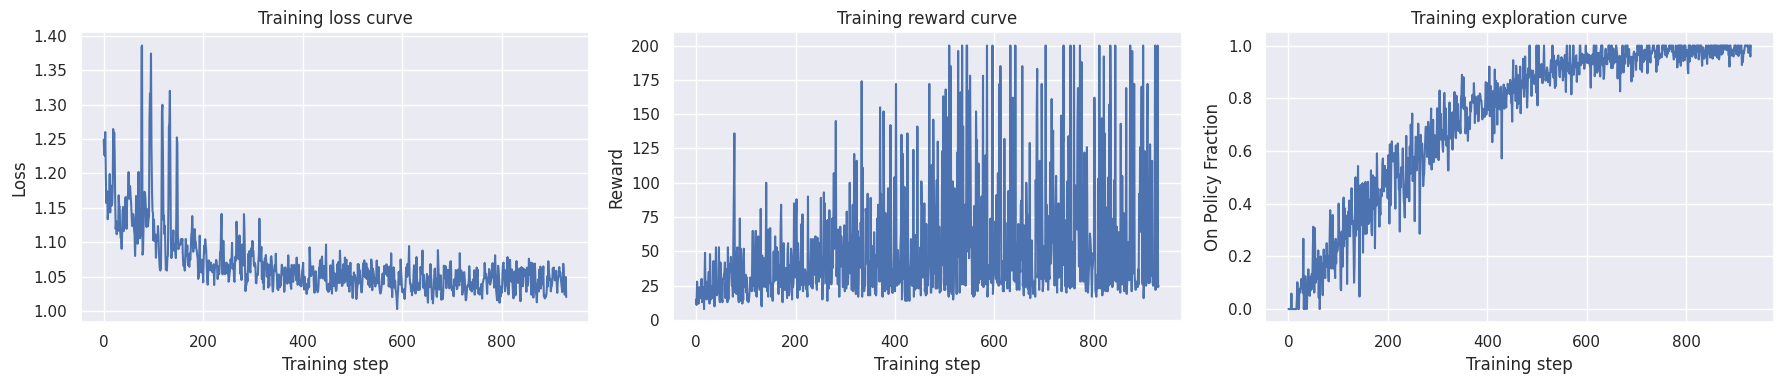

KeyboardInterrupt: 

In [37]:
import jax
from tqdm import trange
import orbax.checkpoint as ocp
import sys



@dataclass
class Params:
    memory_bank_size: int = 100
    memory_prefill_count: int = 25
    batch_size: int = 24
    num_training_steps: int = 100
    max_episode_length: int = 100
    seed: int = 1337

    discount_rate: float = 0.99

    # taken from https://colab.research.google.com/github/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb#scrollTo=R2EnJ-hoUyh3
    explore_start = 1.0            # exploration probability at start
    explore_stop = 0.01            # minimum exploration probability
    decay_rate = 0.0001            # exponential decay rate for exploration prob


    d_model: int = 64
    n_layers: int = 3

    lr: float = 1e-3

    ckpt_dir: str = '/tmp/checkpoints/'

params = Params(
    num_training_steps=1000,
    max_episode_length=200,
    lr=1e-4,
    discount_rate=0.99,
    d_model=64,
    n_layers=1,

)
rngs = nnx.Rngs(default=params.seed)

num_actions = env.action_space.n
dim_in = env.observation_space.shape[0]

qnet = QNet(dim_in, params.d_model, num_actions, params.n_layers, rngs)
optimizer = nnx.Optimizer(qnet, optax.adamw(params.lr), wrt=nnx.Param)
ckpt_dir = ocp.test_utils.erase_and_create_empty(params.ckpt_dir)
checkpointer = ocp.StandardCheckpointer()


# memory = random_init_memory_bank(params.memory_bank_size, params.memory_prefill_episode_count, params.max_episode_length)
memory = random_init_memory_bank_v2(params.memory_bank_size, params.memory_prefill_episode_count, params.max_episode_length)

def loss_fn(model, s_t_BD, a_t_B, target_qhat_tp1_B, rngs_for_loss):
    qhat_t_BA = qnet(s_t_BD)
    q_t_B = qhat_t_BA.take(a_t_B, axis=1)  # prediction
    return ((q_t_B - target_qhat_tp1_B) ** 2)

batched_loss_fn = jax.vmap(loss_fn, in_axes=(None, 0, 0, 0, None))
@nnx.jit
def train_step(model, optimizer, batch, rngs):
    q_tp1_BA = qnet(batch.s_tp1_BD)
    q_tp1_B = q_tp1_BA.max(axis=1)
    # if batch.done_t_B then q_tp1_B = 0
    # jax.debug.print("{x}", x=batch.done_t_B)
    # print("Some output", flush=True)
    q_tp1_B *= (1 - batch.done_t_B)
    qhat_tp1_B = batch.r_t_B + params.discount_rate * q_tp1_B  # target

    def closure(model, rngs_for_closure):
        return batched_loss_fn(model, batch.s_t_BD, batch.a_t_B, qhat_tp1_B, rngs_for_closure)

    (loss, grads) = nnx.value_and_grad(closure)(model, rngs)

    # return loss, grads
    optimizer.update(grads)
    return loss


def play(model, num_steps, exploration, return_frames, rngs, env, current_state, verbose: bool = False) -> tuple[list[Datum], list[np.ndarray], np.ndarray | None]:
    if env is None:
        env = make_env()
        current_state, _ = env.reset()
    else:
        assert current_state is not None

    trajectory = []

    for step in range(num_steps):
        if return_frames:
            frame = env.render()
        else:
            frame = None
        random_action = env.action_space.sample()
        if model is not None:
            qhat_t_BA = model(current_state)
            action = qhat_t_BA.argmax().item()
            is_policy = True
            if verbose:
                print(f"{current_state=} {qhat_t_BA=} {action=}")
        else:
            action = random_action
            is_policy = False

        if jax.random.bernoulli(rngs.params(), exploration, shape=None):
            is_policy = False
            action = random_action

        new_state, reward, t0, t1, info = env.step(action)
        done = t0 or t1
        datum = Datum(
            s_t=current_state,
            a_t=jnp.asarray(action),
            r_t=jnp.asarray(reward),
            s_tp1=new_state,
            done_t=done,
            is_policy_t=is_policy,
            frame_hwc=frame,
        )
        current_state = new_state
        trajectory.append(datum)

        if done:
            current_state = None
            break

    return trajectory, current_state


from tqdm.notebook import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

loss_history = []
reward_history = []
on_policy_step = []
plot_every = 10  # update plot every N steps

pbar = trange(params.num_training_steps, desc="Training", dynamic_ncols=True)
num_updates = 0

for epoch_idx in pbar:  # Each step is a new session
    current_state, _ = env.reset()
    # TODO: do we need to take a random action?
    reward_history.append(0)
    loss_history.append([])
    on_policy_step.append([])

    for step_idx in range(params.max_episode_length):
        num_updates += 1
        explore_p = params.explore_stop + (params.explore_start - params.explore_stop) * np.exp(-params.decay_rate * num_updates)
        if current_state is None:
            break

        # sample batch_size trajectories
        trajectory, current_state = play(
            qnet,
            # what roll out do we want?
            1,
            explore_p,
            return_frames=False,
            rngs=rngs,
            env=env,
            current_state=current_state,
        )
        reward_history[-1] = reward_history[-1] + trajectory[0].r_t.item()
        on_policy_step[-1].append(trajectory[0].is_policy_t)
        for step in trajectory:
            memory.append(step)

        batch = Batch.from_list(memory.sample(params.batch_size))
        loss = train_step(qnet, optimizer, batch, rngs)
        loss_value = float(loss)
        loss_history[-1].append(loss_value)

        # update tqdm bar
        pbar.set_postfix(loss=loss_value)

        # update seaborn loss curve
        if ((epoch_idx % plot_every == 0) or (epoch_idx == params.num_training_steps - 1)) and ((current_state is None) or (step_idx == params.max_episode_length - 1)):
            clear_output(wait=True)

            # keep a bit of textual context
            print(f"Step {epoch_idx+1}/{params.num_training_steps}, loss={loss_value:.4f}. After {step_idx} steps")
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
            sns.lineplot(x=range(len(loss_history)), y=[np.mean(l) for l in loss_history], ax=axes[0])
            axes[0].set_xlabel("Training step")
            axes[0].set_ylabel("Loss")
            axes[0].set_title("Training loss curve")

            sns.lineplot(x=range(len(reward_history)), y=reward_history, ax=axes[1])
            axes[1].set_xlabel("Training step")
            axes[1].set_ylabel("Reward")
            axes[1].set_title("Training reward curve")

            sns.lineplot(x=range(len(on_policy_step)), y=[np.mean(l) for l in on_policy_step], ax=axes[2])
            axes[2].set_xlabel("Training step")
            axes[2].set_ylabel("On Policy Fraction")
            axes[2].set_title("Training exploration curve")

            plt.tight_layout()
            plt.show()

_, state = nnx.split(qnet)
checkpointer.save(ckpt_dir / 'state', state)

In [31]:
trajectory, current_state = play(
    qnet,
    # what roll out do we want?
    1000,
    0.0,
    return_frames=True,
    rngs=rngs,
    env=None,
    current_state=None,
    verbose=True
)
print(sum([d.is_policy_t for d in trajectory]) / len(trajectory))
_frames = [d.frame_hwc for d in trajectory]
_texts = [f"action: {d.a_t} step: {i}" for i, d in enumerate(trajectory)]
show_mp4_from_frames_imageio(_frames, _texts, fps=2)

current_state=array([-0.03060369,  0.01686896, -0.02253987, -0.00184616], dtype=float32) qhat_t_BA=Array([ 0.009223  , -0.00350585], dtype=float32) action=0
current_state=array([-0.03026631, -0.1779226 , -0.02257679,  0.2836408 ], dtype=float32) qhat_t_BA=Array([-0.07449729, -0.07990793], dtype=float32) action=0
current_state=array([-0.03382477, -0.37271538, -0.01690397,  0.5691185 ], dtype=float32) qhat_t_BA=Array([-0.14897282, -0.15120181], dtype=float32) action=0
current_state=array([-0.04127907, -0.17736048, -0.0055216 ,  0.2711585 ], dtype=float32) qhat_t_BA=Array([-0.07371842, -0.07915515], dtype=float32) action=0
current_state=array([-4.4826284e-02, -3.7240320e-01, -9.8432574e-05,  5.6209475e-01],
      dtype=float32) qhat_t_BA=Array([-0.15096673, -0.15292665], dtype=float32) action=0
current_state=array([-0.05227435, -0.5675238 ,  0.01114346,  0.8547467 ], dtype=float32) qhat_t_BA=Array([-0.23032403, -0.22802505], dtype=float32) action=1
current_state=array([-0.06362482, -0.372

/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
